In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin


In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR  = os.path.join(BASE_DIR, 'data')

METADATA_DIR = os.path.join(BASE_DIR, 'metadata')
FEATURES_DIR = os.path.join(BASE_DIR, 'features')
MODELS_DIR = os.path.join(BASE_DIR, 'models')

os.makedirs(FEATURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(BASE_DIR)
print(DATA_DIR)
print(METADATA_DIR)
print(FEATURES_DIR)
print(MODELS_DIR)

/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin
/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin/data
/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin/metadata
/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin/features
/home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin/models


In [3]:
import numpy as np
import optuna

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import joblib

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [5]:
def tune_RF(
        X,
        y,
        n_splits=5,
        n_trials=100,
        random_state=42,
        n_jobs=-1
    ):

    def _objective(trial):
        params = {
            'n_estimators': trial.suggest_int(
                'n_estimators', 10, 500, step=10
            ),
            'max_depth': trial.suggest_int(
                'max_depth', 5, 50, step=5
            ),
            'criterion': trial.suggest_categorical(
                'criterion', ['gini', 'entropy']
            ),
            'min_samples_split': trial.suggest_int(
                'min_samples_split', 2, 20, step=2
            ),
            'min_samples_leaf': trial.suggest_int(
                'min_samples_leaf', 1, 20, step=1
            ),
            'max_features': trial.suggest_categorical(
                'max_features', ['sqrt', 'log2']
            ),
            'random_state': random_state
        }
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=random_state
        )
        scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            clf = RandomForestClassifier(**params)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            score = accuracy_score(y_test, y_pred)
            scores.append(score)
        return np.mean(scores)

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.SuccessiveHalvingPruner()
    )
    study.optimize(
        _objective,
        n_trials=n_trials,
        show_progress_bar=True,
        n_jobs=n_jobs
    )


    return study.best_params, study.best_value


def train_test_RF(
        X,
        y,
        random_state=42,
    ):
    # Get best parameters from tuning
    best_params, best_value = tune_RF(X, y, random_state=random_state)
    print(f"Best parameters: {best_params} with score: {best_value:.4f}")

    # Train final model with best parameters
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_scaled, y)
    return clf, scaler

In [6]:
data = np.load(
    os.path.join(FEATURES_DIR, 'kincore_Calphaonly.npz'), allow_pickle=True
)
X, y, metadata = data['X'], data['y'], data['metadata']

In [7]:
X = np.c_[
    X,
    [m["normalized_sasa"] for m in metadata]
]

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print(f"Train set size: {train_X.shape}, Validation set size: {val_X.shape}")

Train set size: (2345, 1201), Validation set size: (261, 1201)


In [8]:
model, scaler = train_test_RF(train_X, train_y)

  0%|          | 0/100 [00:00<?, ?it/s]

Best parameters: {'n_estimators': 260, 'max_depth': 25, 'criterion': 'gini', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'} with score: 0.7561


In [9]:
model

,n_estimators,260
,criterion,'gini'
,max_depth,25
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
scaler

,copy,True
,with_mean,True
,with_std,True


In [11]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', model)
])
pipeline

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,260
,criterion,'gini'
,max_depth,25
,min_samples_split,4


Validation accuracy: 0.7471


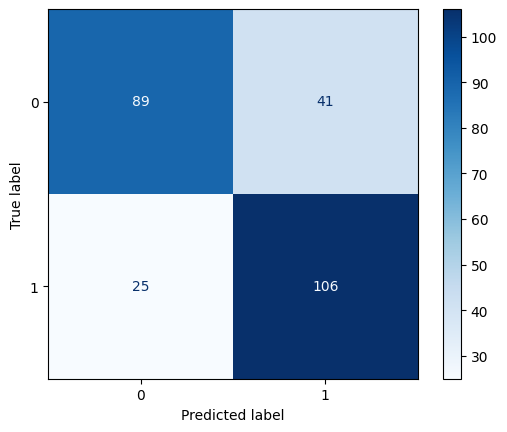

In [12]:
pred = pipeline.predict(val_X)
accuracy = accuracy_score(val_y, pred)
print(f"Validation accuracy: {accuracy:.4f}")
ConfusionMatrixDisplay(
    confusion_matrix(val_y, pred)
).plot(cmap="Blues")

In [13]:
# save the model and scaler
joblib.dump(pipeline, os.path.join(MODELS_DIR, 'rf_pipeline_train90.joblib'))
print(f"Model and scaler saved to {os.path.join(MODELS_DIR, 'rf_pipeline_train90.joblib')}")

Model and scaler saved to /home/cotsios/dsit/2nd-semester/algos-in-struct-bio/project/MLtopKin/models/rf_pipeline_train90.joblib
